In [250]:
import os
import librosa
import librosa.display
import IPython.display as ipd
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.gridspec import GridSpec
import math
from seaborn import heatmap
import seaborn as sns
from matplotlib import transforms
from skimage import metrics
import statistics
import copy
from scipy import optimize

In [251]:
def importAudio(target, reference, output=True):
    if(output):
        display(ipd.Audio(target))
        display(ipd.Audio(reference))

    tArray, tSampleRate = librosa.load(target)
    rArray, rSampleRate = librosa.load(reference)

    tSTFT = librosa.stft(tArray, n_fft=frameSize, hop_length=hopSize)
    rSTFT = librosa.stft(rArray, n_fft=frameSize, hop_length=hopSize)

    tDFT = librosa.stft(tArray, n_fft=frameSize, hop_length=10000000000)
    rDFT = librosa.stft(rArray, n_fft=frameSize, hop_length=10000000000)
    
    return ({"STFT":tSTFT,"DFT":tDFT,"sampleRate":tSampleRate},{"STFT":rSTFT,"DFT":rDFT,"sampleRate":rSampleRate})

In [252]:
def exportAudio(tAudio, mAudio, rAudio):
    print("Target")
    tInverse = librosa.istft(tAudio["STFT"],n_fft=frameSize, hop_length=hopSize)
    display(ipd.Audio(tInverse, rate=tAudio["sampleRate"]))

    print("Matched")
    mInverse = librosa.istft(mAudio["STFT"],n_fft=frameSize, hop_length=hopSize)
    display(ipd.Audio(mInverse, rate=mAudio["sampleRate"]))

    print("Reference")
    rInverse = librosa.istft(rAudio["STFT"],n_fft=frameSize, hop_length=hopSize)
    display(ipd.Audio(rInverse, rate=rAudio["sampleRate"]))

In [253]:
def plotSpectrogram(tAudio, mAudio, rAudio):

    maximum = (max(np.max(np.abs(tAudio["STFT"])**2), np.max(np.abs(rAudio["STFT"])**2)))
    
    # derives the spectrogram from the STFT
    tSpectrogram = librosa.power_to_db(np.abs(tAudio["STFT"])**2, ref=np.max)
    mSpectrogram = librosa.power_to_db(np.abs(mAudio["STFT"])**2, ref=np.max)
    rSpectrogram = librosa.power_to_db(np.abs(rAudio["STFT"])**2, ref=np.max)

    # creates plots of spectrograms
    fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10*figScale, 5*figScale))
    tImg = librosa.display.specshow(tSpectrogram,sr=tAudio["sampleRate"],hop_length=hopSize,x_axis="time",y_axis="mel",cmap="magma",ax=ax[0])
    mImg = librosa.display.specshow(mSpectrogram,sr=mAudio["sampleRate"],hop_length=hopSize,x_axis="time",y_axis="mel",cmap="magma",ax=ax[1])
    rImg = librosa.display.specshow(rSpectrogram,sr=rAudio["sampleRate"],hop_length=hopSize,x_axis="time",y_axis="mel",cmap="magma",ax=ax[2])

    # adjusts appearance
    ax[0].set(title='Target')
    ax[1].set(title='Matched')
    ax[2].set(title='Reference')
    for ax_i in ax:
        ax_i.label_outer()
    fig.colorbar(mImg, ax=[ax[0], ax[1], ax[2]],format='%+2.0f dB')


<h3>Matching based on gain average of frequency bands</h3>

In [254]:
def plotCurve(tCurve,tCurveSmooth,rCurve,rCurveSmooth,mCurve):
    plt.figure(figsize=(10*figScale,5*figScale))

    plt.plot(20*np.log10(tCurve), alpha=0.2, color='blue', label="Target")
    plt.plot(20*np.log10(tCurveSmooth), color='blue', label="Convolved Target")

    plt.plot(20*np.log10(rCurve), alpha=0.2, color='red', label="Reference")
    plt.plot(20*np.log10(rCurveSmooth), color='red', label="Convolved Reference")

    plt.plot(20*np.log10(mCurve), color='green', label="Matched")
    
    plt.xlabel("Frequency Bin")
    plt.ylabel("Gain (dB)")
    plt.legend()

In [255]:
def convolve(curve, smoothing):
    curve = np.ravel(curve)
    kernel = np.ones(smoothing) / smoothing
    curve = np.convolve(curve, kernel, mode='same')
    curve = curve.reshape(len(curve),1)
    return curve

def EQMatching(tAudio, rAudio, smoothing=1, plot=True):
    tCurve = np.abs(tAudio["DFT"])
    tCurveSmooth = convolve(tCurve, smoothing)

    rCurve = np.abs(rAudio["DFT"])
    rCurveSmooth = convolve(rCurve, smoothing)

    scaler = rCurveSmooth / tCurveSmooth
    
    mSTFT = tAudio["STFT"] * scaler
    mDFT = tAudio["DFT"] * scaler
    mAudio = {"STFT":mSTFT,"DFT":mDFT,"sampleRate":tAudio["sampleRate"]}

    if(plot):
        mCurve = np.abs(mDFT)
        plotCurve(tCurve,tCurveSmooth,rCurve,rCurveSmooth,mCurve)
    
    return mAudio

In [844]:
def plotDynamics(tSlice,rSlice,coeff,dynamicBins):

    #Grid
    fig = plt.figure(figsize=(14*figScale, 4*figScale))
    gs = GridSpec(6, 21, figure=fig)

    tLevel = fig.add_subplot(gs[0:3, 0:10])
    rLevel = fig.add_subplot(gs[3:6, 0:10])

    tResponse = fig.add_subplot(gs[0:5, 10:11])
    rResponse = fig.add_subplot(gs[0:5, 11:12])
    mResponse = fig.add_subplot(gs[0:5, 12:13])
    mrResponse = fig.add_subplot(gs[0:5, 13:14])
    preDist = fig.add_subplot(gs[5:6, 10:12])
    postDist = fig.add_subplot(gs[5:6, 12:14])

    mod = fig.add_subplot(gs[0:6, 15:21])
    fig.tight_layout(pad=1.0)
    plt.subplots_adjust(wspace=0.8)

    #abs
    tSlice = np.abs(tSlice)
    mSlice = np.abs(warp(tSlice,coeff))
    rSlice = np.abs(rSlice)



    #Level
    tLevel.plot(np.abs(tSlice),label="Unmatched",color='blue')
    tLevel.plot(np.abs(mSlice),label="Matched",color='red')
    rLevel.plot(np.abs(rSlice),color='green')

    tLevel.set_title('Target')
    tLevel.set_ylabel("Level")
    tLevel.legend()
    tLevel.set_ylim((0,max(max(tSlice),max(rSlice),max(mSlice))))
    rLevel.set_title('Reference')
    rLevel.set_xlabel("Frame")
    rLevel.set_ylabel("Level")
    rLevel.set_ylim((0,max(max(tSlice),max(rSlice),max(mSlice))))
    


    #Response
    tDynamicResponse, rDynamicResponse = getDynamicResponse(tSlice, rSlice, dynamicBins)
    reshape = np.flip(tDynamicResponse.reshape(tDynamicResponse.shape[0], 1))
    heat = heatmap(reshape, ax=tResponse, cmap="magma")
    for _, spine in heat.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)
    reshape = np.flip(rDynamicResponse.reshape(rDynamicResponse.shape[0], 1))
    heat = heatmap(reshape, ax=rResponse, cmap="magma")
    for _, spine in heat.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)
    tResponse.set_xticks([])
    tResponse.set_yticks([])
    rResponse.set_xticks([])
    rResponse.set_yticks([])
    tResponse.set_title('unmatched', fontsize=10)
    rResponse.set_title('ref', fontsize=10)

    mDynamicResponse, mrDynamicResponse = getDynamicResponse(mSlice, rSlice, dynamicBins)
    reshape = np.flip(mDynamicResponse.reshape(tDynamicResponse.shape[0], 1))
    heat = heatmap(reshape, ax=mResponse, cmap="magma")
    for _, spine in heat.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)
    reshape = np.flip(mrDynamicResponse.reshape(rDynamicResponse.shape[0], 1))
    heat = heatmap(reshape, ax=mrResponse, cmap="magma")
    for _, spine in heat.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)
    mResponse.set_xticks([])
    mResponse.set_yticks([])
    mrResponse.set_xticks([])
    mrResponse.set_yticks([])
    mResponse.set_title('matched', fontsize=10)
    mrResponse.set_title('ref', fontsize=10)

    preDist.set_title('Distance:')
    postDist.set_title('Distance:')
    preDist.axis("off")
    postDist.axis("off")
    preDist.text(0.5, 0.5, round(objective([1],tSlice,rSlice,dynamicBins),2), va="center", ha="center")
    postDist.text(0.5, 0.5, round(objective(coeff,tSlice,rSlice,dynamicBins),2), va="center", ha="center")



    #Modifier
    tMax = max(np.abs(tSlice))
    x = np.linspace(0,tMax,100)
    plotCoeff = np.append(coeff[::-1],0)
    y = np.polyval(plotCoeff,x)

    mod.plot(x,x, color='blue')
    mod.plot(x,y, color='red')
    
    mod.set_title('Modifier')
    mod.set_xlabel("Target Level")
    mod.set_ylabel("Matched Level")

In [686]:
def integral(coeffs,a,b):
    intA = 0
    intB = 0
    for i in range(len(coeffs)):
        intA += coeffs[i] * ((a**(i+2))/(i+1))
        intB += coeffs[i] * ((b**(i+2))/(i+2))
    return intB - intA

# Quantify lack of increase- monotonicity. used to penalise loss
def LOI(coeffs,lim):
    p = np.poly1d(np.append(coeffs[::-1],0))
    der = np.polyder(p)
    roots = np.roots(der)
    
    roots = roots[np.where(roots>=0)]
    roots = roots[np.where(roots<=lim)]

    if(len(roots)%2!=0):
        secondDer = np.polyder(der)
        if(secondDer(roots[0])>0):
            roots = np.append(0,roots)
        else:
            roots = np.append(roots,lim)

    total = 0
    for i in range(0,len(roots),2):
        total += abs(integral(coeffs,roots[i],roots[i+1]))
    return total/lim

In [556]:
# Calculate the dynamic response historgrams, used for calculating loss of frequency bins
def getDynamicResponse(tFreqBin, rFreqBin, dynamicBins):
    # tFreqBin may already be absolute if coming from objective funct. abs(abs()) will flatten cardinality and break functionality
    if(np.any(np.iscomplex(tFreqBin))):
        tAbs = np.abs(tFreqBin)
    else:
        tAbs=tFreqBin
    rAbs = np.abs(rFreqBin)

    # The minimum and maximum gain values across target and reference combined
    dynamicRange = (min(min(tAbs),min(rAbs)), max(max(tAbs),max(rAbs)))

    # Histograms of how commonly certain gain ranges occur, in dB
    tDynamicResponse = np.histogram(tAbs,bins=dynamicBins,range=dynamicRange)[0]
    rDynamicResponse = np.histogram(rAbs,bins=dynamicBins,range=dynamicRange)[0]

    return tDynamicResponse, rDynamicResponse

# Calculate loss between two dynamic responses
def getDistance(tDynamicResponse, rDynamicResponse, tMax, rMax, dynamicBins):
    A = tDynamicResponse / sum(tDynamicResponse)
    B = rDynamicResponse / sum(rDynamicResponse)
    
    n = len(A)
    dist = np.zeros(n)
    for x in range(n-1):
        dist[x+1] = A[x]-B[x]+dist[x]
    wasserstein = np.sum(abs(dist))

    if(tMax > rMax):
        wasserstein = wasserstein * (tMax / rMax)
    
    wasserstein = wasserstein / dynamicBins
    
    return wasserstein

# Warp the dynamics of a frequency bin by applying a polynomial equation
def warp(bin,coeff):
    warped = np.zeros_like(bin)
    for i in range(len(coeff)):
        component = coeff[i] * (bin*(np.abs(bin)**i))
        warped += component
    
    return warped

In [816]:
def dynamicResponses(rAudio,fidelity):
    bins = len(rAudio["STFT"])
    dynamicResponses = np.zeros((bins,fidelity))
    maxGain = 0
    for i in range(bins):
        bin = np.abs(rAudio["STFT"][i,:])
        if(max(bin)>maxGain):
            maxGain = max(bin)

    for i in range(bins):
        bin = np.abs(rAudio["STFT"][i,:])
        dynamicResponses[i]=np.histogram(bin,bins=fidelity,range=(0,maxGain))[0]

    plt.figure(figsize=(7*figScale,5*figScale))

    ax = sns.heatmap(dynamicResponses,cmap="magma")
    ax.invert_yaxis()
    plt.locator_params(nbins=10)
    plt.xlabel('gain')
    plt.ylabel('frequency bin')
    plt.show()


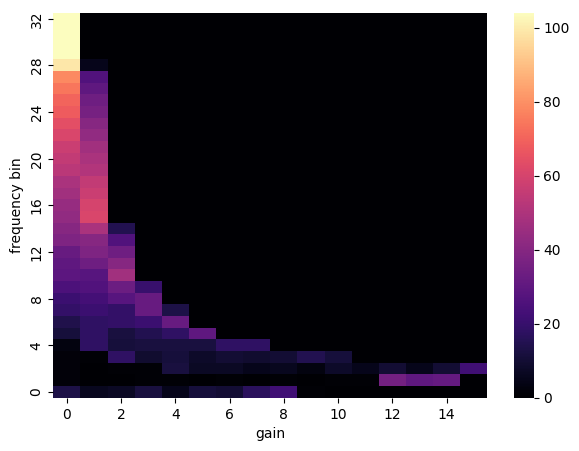

In [819]:
dynamicResponses(rAudio,16)

In [258]:
def bruteForceMatching(tAudio,rAudio,dynamicBins,freqBin, testDistance, steps):
    multipliers = np.linspace(0,testDistance,steps)
    distances = np.zeros((steps,steps))
    
    for i in range(steps):
        for j in range(steps):
            matched = warp(tAudio["STFT"][freqBin,:],[multipliers[j],multipliers[i]])
            #matched = multipliers[i]*tAudio["STFT"][freqBin,:]**2 + multipliers[j]*tAudio["STFT"][freqBin,:]
            tDynamicResponse, rDynamicReponse = getDynamicResponse(matched,rAudio["STFT"][freqBin,:],dynamicBins)
            tMax = max(np.abs(matched))
            rMax = max(np.abs(rAudio["STFT"][freqBin,:]))
            distances[i,j] = getDistance(tDynamicResponse,rDynamicReponse,tMax,rMax,dynamicBins)
    
    plt.figure(figsize=(7*figScale,5*figScale))

    ax = sns.heatmap(distances,xticklabels=multipliers.round(2),yticklabels=multipliers.round(2),cmap="magma_r")
    ax.invert_yaxis()
    plt.locator_params(nbins=10)
    plt.xlabel('x')
    plt.ylabel('x^2')
    plt.show()

In [907]:
# the objective function upon which the dual annealing operates
def objective(x, *params):
    tSlice, rSlice, dynamicBins = params

    mSlice = warp(np.abs(tSlice), x)
    mDynamicResponse, rDynamicReponse = getDynamicResponse(mSlice,rSlice,dynamicBins)
    mMax = max(np.abs(mSlice))
    rMax = max(np.abs(rSlice))
    
    return getDistance(mDynamicResponse,rDynamicReponse,mMax,rMax,dynamicBins) + (LOI(x,max(np.abs(tSlice)))*1000)

# perform dual annealing
def findMin(tSlice,rSlice,dynamicBins,order,searchSize,plot=False):
    order = order
    searchSize = searchSize
    bounds = list(zip([-searchSize]*order,[searchSize]*order))

    sol = optimize.dual_annealing(objective, bounds=bounds, args=(tSlice,rSlice,dynamicBins))
    #sol = optimize.minimize(objective, method="Powell", x0=[15.43343102, -58.07865526,  59.84474211], bounds=bounds, args=(tSlice,rSlice,dynamicBins))

    if(plot):
        plotDynamics(tSlice, rSlice, sol['x'], dynamicBins)
    return sol['x']

# perform powell minimisation
def powell(tSlice,rSlice,initial,dynamicBins,order,searchSize,plot=False):
    order = order
    searchSize = searchSize
    bounds = list(zip([-searchSize]*order,[searchSize]*order))
    #print(initial)
    #sol = optimize.dual_annealing(objective, bounds=bounds, args=(tSlice,rSlice,dynamicBins))
    sol = optimize.minimize(objective, method="Powell", x0=initial, bounds=bounds, args=(tSlice,rSlice,dynamicBins))

    if(plot):
        plotDynamics(tSlice, rSlice, sol['x'], dynamicBins)
    return sol['x']


In [752]:
def plotModifiers(coeffs,maxes,optimisation,plotRange=None):
    maxT = 0
    maxM = 0

    if(type(plotRange) != tuple):
        plotRange = (0,len(coeffs))

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    for i in range(plotRange[0],plotRange[1]):
        x = np.linspace(0,maxes[i],100)
        plotCoeff = np.append(coeffs[i][::-1],0)
        y = np.polyval(plotCoeff,x)
        if(optimisation[i]=="SA"):
            color="red"
        else:
            color="blue"
        ax.plot(x,y,zs=i, zdir='y',color=color)
        ax.plot(x,x,zs=i, zdir='y',color=color, alpha=0.2)

        if(maxes[i]>maxT):
            maxT=maxes[i]
        if(max(y)>maxM):
            maxM=max(y)

    ax.set_zlim(0, maxM)
    ax.set_xlim(0, maxT)
    ax.set_zlabel("Matched Level")
    ax.set_ylabel("Frequency Bin")
    ax.set_xlabel("Target Level")
    ax.view_init(20,-120)
    ax.grid(False)
    plt.show()

<h1>Different matching strategies</h1>

In [750]:
def findMatching(tAudio,rAudio,dynamicBins,order,searchSize,jump,plot=False,plotRange=None):
    bins = len(tAudio["STFT"])

    coeffs = np.zeros((bins,order))
    maxes = np.zeros(bins)
    optimisation = [None] * bins

    # First S.A
    print("SA 0")
    i=0
    tSlice = tAudio["STFT"][i,:]
    rSlice = rAudio["STFT"][i,:]
    coeffs[i]=findMin(tSlice,rSlice,dynamicBins,order,searchSize)
    maxes[i]=max(np.abs(tSlice))
    optimisation[i]="SA"

    for block in range(math.floor(bins/jump)):
        # Subblock SA
        i=(block*jump)+jump
        print("SA",i)
        tSlice = tAudio["STFT"][i,:]
        rSlice = rAudio["STFT"][i,:]
        coeffs[i]=findMin(tSlice,rSlice,dynamicBins,order,searchSize)
        maxes[i]=max(np.abs(tSlice))
        optimisation[i]="SA"

        for subblock in range(math.floor(jump/2)):
            # right side (!=0 because 0 is SA)
            if(subblock!=0):
                i=(block*jump)+(jump-subblock)
                tSlice = tAudio["STFT"][i,:]
                rSlice = rAudio["STFT"][i,:]
                print(i,":","(bin",(block*jump),"*",(subblock/jump),") + (bin",((block+1)*jump),"*",((jump-subblock)/jump),")")
                initial = (coeffs[block*jump]*(subblock/jump)) + (coeffs[(block+1)*jump]*((jump-subblock)/jump))
                coeffs[i]=powell(tSlice,rSlice,initial,dynamicBins,order,searchSize)
                maxes[i]=max(np.abs(tSlice))
                optimisation[i]="Powell"
            
            # left side
            i=1+(block*jump)+subblock
            tSlice = tAudio["STFT"][i,:]
            rSlice = rAudio["STFT"][i,:]
            print(i,":","(bin",(block*jump),"*",((jump-subblock-1)/jump),") + (bin",((block+1)*jump),"*",((subblock+1)/jump),")")
            initial = (coeffs[block*jump]*((jump-subblock-1)/jump)) + (coeffs[(block+1)*jump]*((subblock+1)/jump))
            coeffs[i]=powell(tSlice,rSlice,initial,dynamicBins,order,searchSize)
            maxes[i]=max(np.abs(tSlice))
            optimisation[i]="Powell"
        
        # middle if jump is odd
        if(jump%2!=0):
            i=(block*jump)+math.ceil(jump/2)
            tSlice = tAudio["STFT"][i,:]
            rSlice = rAudio["STFT"][i,:]
            print(i,":","(bin",(block*jump),"*",((subblock+1)/jump),") + (bin",((block+1)*jump),"*",((jump-subblock-1)/jump),")")
            initial = (coeffs[block*jump]*((subblock+1)/jump)) + (coeffs[(block+1)*jump]*((jump-subblock-1)/jump))
            coeffs[i]=powell(tSlice,rSlice,initial,dynamicBins,order,searchSize)
            maxes[i]=max(np.abs(tSlice))
            optimisation[i]="Powell"

    if(plot):
        plotModifiers(coeffs,maxes,optimisation,plotRange)
    return coeffs


In [838]:
def findMatchingCentre(tAudio,rAudio,dynamicBins,order,searchSize,plot=False,plotRange=None):
    bins = len(tAudio["STFT"])

    coeffs = np.zeros((bins,order))
    maxes = np.zeros(bins)
    optimisation = [None] * bins

    # Centre S.A
    i=math.floor(bins/2)
    tSlice = tAudio["STFT"][i,:]
    rSlice = rAudio["STFT"][i,:]
    coeffs[i]=findMin(tSlice,rSlice,dynamicBins,order,searchSize)
    maxes[i]=max(np.abs(tSlice))
    optimisation[i]="SA"

    # Propagate down
    while(i>0):
        i-=1
        tSlice = tAudio["STFT"][i,:]
        rSlice = rAudio["STFT"][i,:]
        initial = coeffs[i+1]
        coeffs[i]=powell(tSlice,rSlice,initial,dynamicBins,order,searchSize)
        maxes[i]=max(np.abs(tSlice))
        optimisation[i]="Powell"

    # Propagate up
    i=math.floor(bins/2)
    while(i<bins-1):
        i+=1
        tSlice = tAudio["STFT"][i,:]
        rSlice = rAudio["STFT"][i,:]
        initial = coeffs[i-1]
        coeffs[i]=powell(tSlice,rSlice,initial,dynamicBins,order,searchSize)
        maxes[i]=max(np.abs(tSlice))
        optimisation[i]="Powell"
    
    if(plot):
        plotModifiers(coeffs,maxes,optimisation,plotRange)
    return coeffs


In [916]:
def findMatchingCentreScale(tAudio,rAudio,dynamicBins,order,searchSize,plot=False,plotRange=None):
    bins = len(tAudio["STFT"])

    coeffs = np.zeros((bins,order))
    maxes = np.zeros(bins)
    optimisation = [None] * bins

    # Centre S.A
    i=math.floor(bins/2)
    tSlice = tAudio["STFT"][i,:]
    rSlice = rAudio["STFT"][i,:]
    coeffs[i]=findMin(tSlice,rSlice,dynamicBins,order,searchSize)
    maxes[i]=max(np.abs(tSlice))
    optimisation[i]="SA"

    # Propagate down
    while(i>0):
        i-=1
        tSlice = tAudio["STFT"][i,:]
        rSlice = rAudio["STFT"][i,:]
        maxes[i]=max(np.abs(tSlice))
        
        if(maxes[i]>maxes[i+1]):
            initial = coeffs[i+1] * (maxes[i+1]/maxes[i])
        else:
            initial = coeffs[i+1]
        
        coeffs[i]=powell(tSlice,rSlice,initial,dynamicBins,order,searchSize)
        optimisation[i]="Powell"

    # Propagate up
    i=math.floor(bins/2)
    while(i<bins-1):
        i+=1
        tSlice = tAudio["STFT"][i,:]
        rSlice = rAudio["STFT"][i,:]
        maxes[i]=max(np.abs(tSlice))

        if(maxes[i]>maxes[i-1]):
            initial = coeffs[i-1] * (maxes[i-1]/maxes[i])
        else:
            initial = coeffs[i-1]
        
        coeffs[i]=powell(tSlice,rSlice,initial,dynamicBins,order,searchSize)
        optimisation[i]="Powell"
    
    if(plot):
        plotModifiers(coeffs,maxes,optimisation,plotRange)
    return coeffs


In [861]:
def findMatchingCentreDistanceCheck(tAudio,rAudio,dynamicBins,order,searchSize,plot=False,plotRange=None):
    bins = len(tAudio["STFT"])

    coeffs = np.zeros((bins,order))
    maxes = np.zeros(bins)
    optimisation = [None] * bins

    # Centre S.A
    i=math.floor(bins/2)
    tSlice = tAudio["STFT"][i,:]
    rSlice = rAudio["STFT"][i,:]
    coeffs[i]=findMin(tSlice,rSlice,dynamicBins,order,searchSize)
    maxes[i]=max(np.abs(tSlice))
    optimisation[i]="SA"

    # Propagate down
    while(i>0):
        i-=1
        tSlice = tAudio["STFT"][i,:]
        rSlice = rAudio["STFT"][i,:]
        initial = coeffs[i+1]
        coeffs[i]=powell(tSlice,rSlice,initial,dynamicBins,order,searchSize)
        maxes[i]=max(np.abs(tSlice))
        optimisation[i]="Powell"

        d1,d2 = getDynamicResponse(warp(tSlice,coeffs[i]),rSlice,dynamicBins)
        d3,d4 = getDynamicResponse(tSlice,rSlice,dynamicBins)
        if(getDistance(d1,d2,max(warp(tSlice,coeffs[i])),max(rSlice),dynamicBins)>getDistance(d3,d4,max(tSlice),max(rSlice),dynamicBins)):
            print("higher dist")
            coeffs[i]=findMin(tSlice,rSlice,dynamicBins,order,searchSize)
            maxes[i]=max(np.abs(tSlice))
            optimisation[i]="SA"

    # Propagate up
    i=math.floor(bins/2)
    while(i<bins-1):
        i+=1
        tSlice = tAudio["STFT"][i,:]
        rSlice = rAudio["STFT"][i,:]
        initial = coeffs[i-1]
        coeffs[i]=powell(tSlice,rSlice,initial,dynamicBins,order,searchSize)
        maxes[i]=max(np.abs(tSlice))
        optimisation[i]="Powell"

        d1,d2 = getDynamicResponse(warp(tSlice,coeffs[i]),rSlice,dynamicBins)
        d3,d4 = getDynamicResponse(tSlice,rSlice,dynamicBins)
        if(getDistance(d1,d2,max(warp(tSlice,coeffs[i])),max(rSlice),dynamicBins)>getDistance(d3,d4,max(tSlice),max(rSlice),dynamicBins)):
            print("higher dist")
            coeffs[i]=findMin(tSlice,rSlice,dynamicBins,order,searchSize)
            maxes[i]=max(np.abs(tSlice))
            optimisation[i]="SA"
    
    if(plot):
        plotModifiers(coeffs,maxes,optimisation,plotRange)
    return coeffs


In [867]:
def findMatchingMax(tAudio,rAudio,dynamicBins,order,searchSize,plot=False,plotRange=None):
    bins = len(tAudio["STFT"])

    coeffs = np.zeros((bins,order))
    maxes = np.zeros(bins)
    optimisation = [None] * bins

    maxGain = 0
    maxI = 0
    for i in range(bins):
        tSlice = np.abs(tAudio["STFT"][i,:])
        if(max(tSlice)>maxGain):
            maxGain = max(tSlice)
            maxI = i
    

    # Centre S.A
    i=maxI
    tSlice = tAudio["STFT"][i,:]
    rSlice = rAudio["STFT"][i,:]
    coeffs[i]=findMin(tSlice,rSlice,dynamicBins,order,searchSize)
    maxes[i]=max(np.abs(tSlice))
    optimisation[i]="SA"

    # Propagate down
    while(i>0):
        i-=1
        tSlice = tAudio["STFT"][i,:]
        rSlice = rAudio["STFT"][i,:]
        initial = coeffs[i+1]
        coeffs[i]=powell(tSlice,rSlice,initial,dynamicBins,order,searchSize)
        maxes[i]=max(np.abs(tSlice))
        optimisation[i]="Powell"

    # Propagate up
    i=maxI
    while(i<bins-1):
        i+=1
        tSlice = tAudio["STFT"][i,:]
        rSlice = rAudio["STFT"][i,:]
        initial = coeffs[i-1]
        coeffs[i]=powell(tSlice,rSlice,initial,dynamicBins,order,searchSize)
        maxes[i]=max(np.abs(tSlice))
        optimisation[i]="Powell"
    
    if(plot):
        plotModifiers(coeffs,maxes,optimisation,plotRange)
    return coeffs


In [877]:
def findMatchingMaxSameInit(tAudio,rAudio,dynamicBins,order,searchSize,plot=False,plotRange=None):
    bins = len(tAudio["STFT"])

    coeffs = np.zeros((bins,order))
    maxes = np.zeros(bins)
    optimisation = [None] * bins

    maxGain = 0
    maxI = 0
    for i in range(bins):
        tSlice = np.abs(tAudio["STFT"][i,:])
        if(max(tSlice)>maxGain):
            maxGain = max(tSlice)
            maxI = i
    

    # Centre S.A
    i=maxI
    tSlice = tAudio["STFT"][i,:]
    rSlice = rAudio["STFT"][i,:]
    coeffs[i]=findMin(tSlice,rSlice,dynamicBins,order,searchSize)
    maxes[i]=max(np.abs(tSlice))
    optimisation[i]="SA"

    # Propagate down
    while(i>0):
        i-=1
        tSlice = tAudio["STFT"][i,:]
        rSlice = rAudio["STFT"][i,:]
        initial = coeffs[maxI]
        coeffs[i]=powell(tSlice,rSlice,initial,dynamicBins,order,searchSize)
        maxes[i]=max(np.abs(tSlice))
        optimisation[i]="Powell"

    # Propagate up
    i=maxI
    while(i<bins-1):
        i+=1
        tSlice = tAudio["STFT"][i,:]
        rSlice = rAudio["STFT"][i,:]
        initial = coeffs[maxI]
        coeffs[i]=powell(tSlice,rSlice,initial,dynamicBins,order,searchSize)
        maxes[i]=max(np.abs(tSlice))
        optimisation[i]="Powell"
    
    if(plot):
        plotModifiers(coeffs,maxes,optimisation,plotRange)
    return coeffs


In [708]:
def match(tAudio,coeffs):
    mAudio = copy.deepcopy(tAudio)
    for i in range(len(tAudio["STFT"])):
        bin = tAudio["STFT"][i,:]
        mAudio["STFT"][i,:] = warp(bin,coeffs[i])
    return mAudio

In [893]:
def totalDistance(tAudio,mAudio,rAudio,dynamicBins):
    preDist = 0
    postDist = 0
    for i in range(len(tAudio["STFT"])):
        tSlice = tAudio["STFT"][i,:]
        mSlice = mAudio["STFT"][i,:]
        rSlice = rAudio["STFT"][i,:]

        tMax = max(np.abs(tSlice))
        mMax = max(np.abs(mSlice))
        rMax = max(np.abs(rSlice))

        tDynamicResponse, rDynamicReponse = getDynamicResponse(tSlice,rSlice,dynamicBins)
        preDist += getDistance(tDynamicResponse,rDynamicReponse,tMax,rMax,dynamicBins)
        
        mDynamicResponse, rDynamicReponse = getDynamicResponse(mSlice,rSlice,dynamicBins)
        postDist += getDistance(mDynamicResponse,rDynamicReponse,mMax,rMax,dynamicBins)
    
    print("pre:",preDist/dynamicBins)
    print("post:",postDist/dynamicBins)

<h1>Execution</h1>

In [926]:
#frameSize=2048
frameSize=64
hopSize=512

figScale = 1

In [714]:
print(len(tAudio["STFT"]))

33


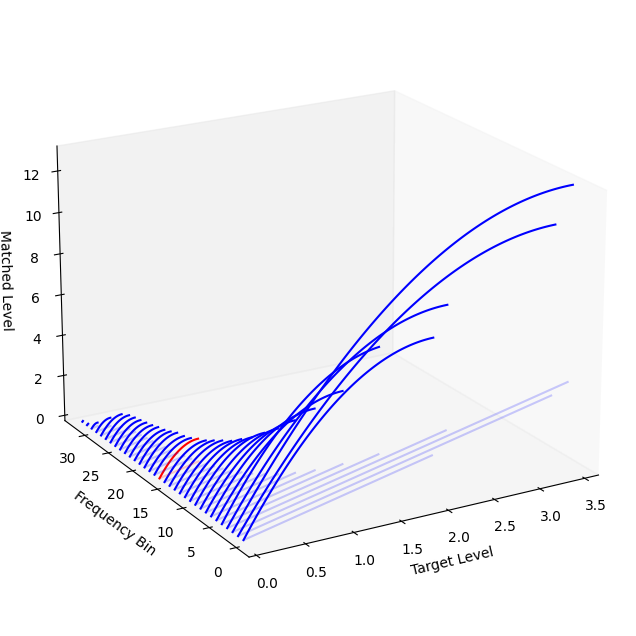

pre: 0.2607421875
post: 0.050411790639023256


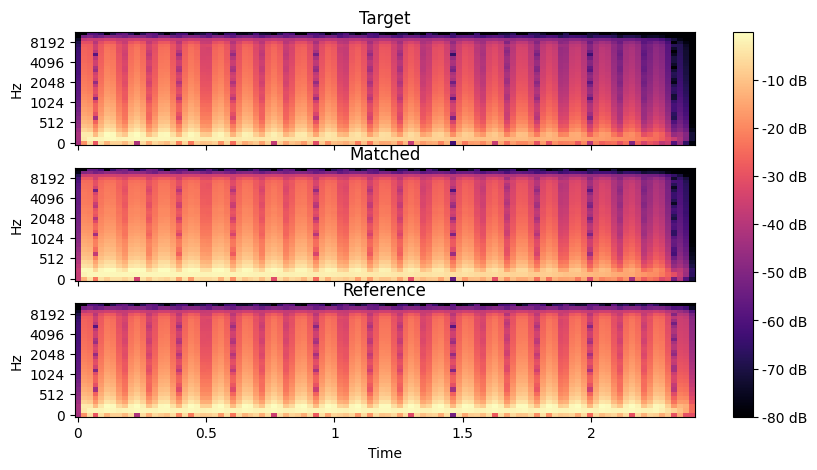

In [933]:
tAudio, rAudio = importAudio(target="tonequiet.wav",reference="toneloud.wav", output=False)

#tAudio, rAudio = importAudio(target="audio_mono.wav",reference="audo3_mono.wav", output=False)


#coeffs = findMatching(tAudio,rAudio,dynamicBins=64,order=2,searchSize=100,jump=8,plot=True,plotRange=(0,33))
coeffs = findMatchingCentreScale(tAudio,rAudio,dynamicBins=64,order=2,searchSize=100,plot=True)
mAudio = match(tAudio,coeffs)
totalDistance(tAudio,mAudio,rAudio,64)
plotSpectrogram(tAudio, mAudio, rAudio)


#tSlice = tAudio["STFT"][2,:]
#rSlice = rAudio["STFT"][2,:]
#findMin(tSlice,rSlice,dynamicBins=64,order=2,searchSize=100,plot=True)

#tSlice = tAudio["STFT"][100,:]
#mSlice1 = warp(np.abs(tSlice), [-1])
#mSlice2 = warp(np.abs(tSlice), [1])
#mSlice1==mSlice2

#plotDynamics(tAudio["STFT"][100,:],rAudio["STFT"][100,:],[-18.73538423,64.65852413,-67.87420381,],64)
#plotDynamics(tAudio["STFT"][100,:],rAudio["STFT"][100,:],[18.73538423,-64.65852413,67.87420381,],64)


#np.abs(tAudio["STFT"][100,5]*-10)

#tAudio, rAudio = importAudio(target="audio_mono.wav",reference="audio2_mono.wav", output=True)

#[-67.87420381,64.65852413,-18.73538423,0]

#mAudio = EQMatching(tAudio,rAudio,smoothing=100, plot=True)



#exportAudio(tAudio, mAudio, rAudio)

In [ ]:
plotSpectrogram(tAudio, mAudio, rAudio)

In [915]:
np.array([1,2,4]) * 3

array([ 3,  6, 12])

In [934]:
exportAudio(tAudio, mAudio, rAudio)

Target


Matched


Reference


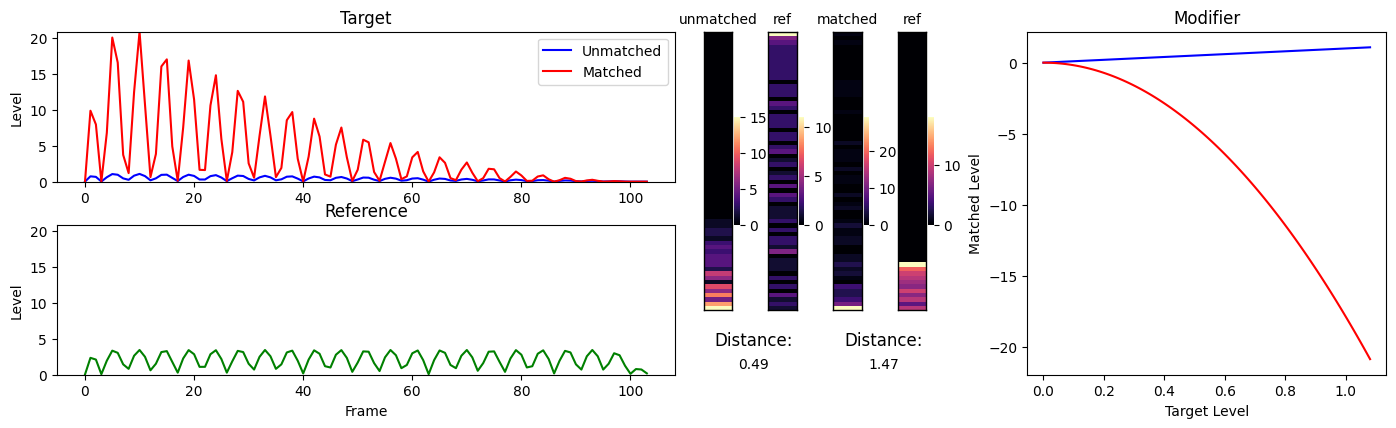

In [887]:
plotDynamics(tAudio["STFT"][6,:], rAudio["STFT"][6,:], coeffs[6], 64)

array([ 7.39601826, -3.42437575])

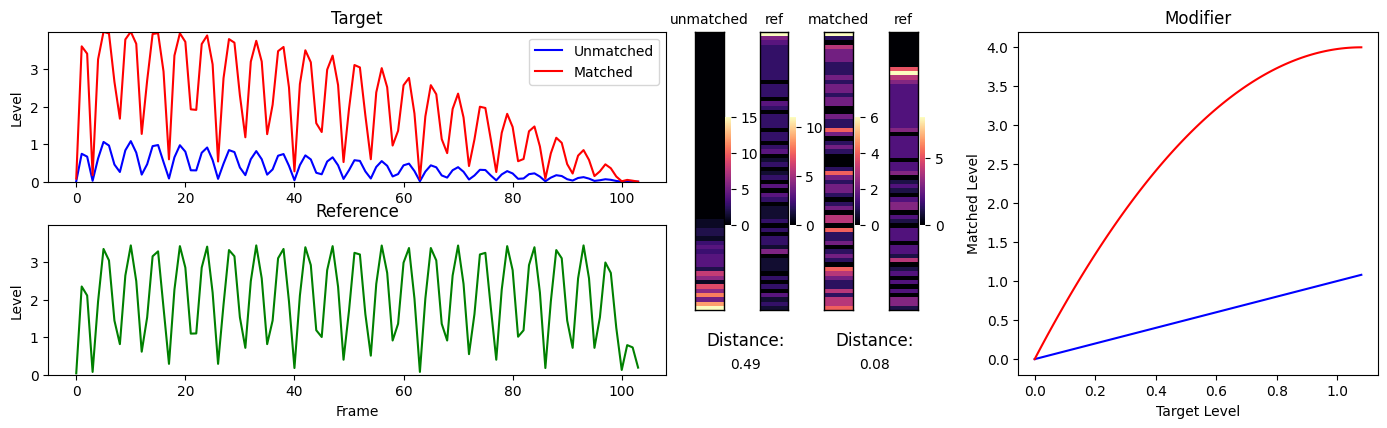

In [888]:
findMin(tAudio["STFT"][6,:], rAudio["STFT"][6,:],dynamicBins=64,order=2,searchSize=100,plot=True)